### Redes Neurais e Arquiteturas Profundas
#### **MBA em Ciências de Dados**

### *Módulo 1 - Introdução ao Aprendizado Profundo*

Moacir A. Ponti - ICMC/USP

-

## Exemplo de uso de redes neurais profundas com dados estruturados

### Problema: Classificação de cidades segundo sua população, UF e PIB



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split

df = pd.read_csv("vw_pib_percapita_clean.csv")
df = df.dropna()

In [2]:
df

,UF,PIB,Pop_est_2009,classe
0,BAHIA,5.788399e+04,18433,1
1,RIO GRANDE DO SUL,4.572388e+04,4000,2
2,ESPIRITO SANTO,1.978263e+07,320156,4
3,MINAS GERAIS,2.478160e+05,21424,2
4,PIAUÍ,2.095138e+04,7895,1
...,...,...,...,...
5561,SANTA CATARINA,1.876289e+05,9737,2
5562,PARANÁ,1.385535e+05,13983,2
5563,SÃO PAULO,5.320191e+05,29639,2
5564,RIO GRANDE DO SUL,2.198064e+04,3067,1


Vamos obter uma codificação numérica para o estado (UF)

In [3]:
ufcode = df['UF'].astype("category").cat.codes
df.insert(1,"UF_code", ufcode.astype(float))
df

,UF,UF_code,PIB,Pop_est_2009,classe
0,BAHIA,4.0,5.788399e+04,18433,1
1,RIO GRANDE DO SUL,20.0,4.572388e+04,4000,2
2,ESPIRITO SANTO,7.0,1.978263e+07,320156,4
3,MINAS GERAIS,12.0,2.478160e+05,21424,2
4,PIAUÍ,17.0,2.095138e+04,7895,1
...,...,...,...,...,...
5561,SANTA CATARINA,23.0,1.876289e+05,9737,2
5562,PARANÁ,13.0,1.385535e+05,13983,2
5563,SÃO PAULO,25.0,5.320191e+05,29639,2
5564,RIO GRANDE DO SUL,20.0,2.198064e+04,3067,1


## Problema: discriminar cidades de classe 1 e 2 das demais

<AxesSubplot:>

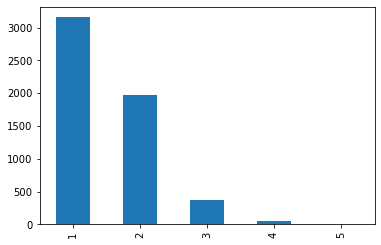

In [4]:
df['classe'].value_counts().plot(kind = 'bar')

In [5]:
df['classe'].value_counts()

1    3157
2    1977
3     376
4      51
5       5
Name: classe, dtype: int64

### Vamos converter o dataframe para numpy array e depois separar as features (entrada) dos alvos (saída)

In [6]:
nparray = df.to_numpy()

In [7]:
features = (nparray[:,1:-1]).astype(float)
targets = (nparray[:,-1] > 2).astype(int)
print("Features = ", features.shape)
print("Targets = ", targets.shape)

Features =  (5566, 3)
Targets =  (5566,)


### 1) Preparando conjuntos de treinamento e teste

Aqui vou fazer de forma simples pois quero apenas mostrar o treinamento da rede, pegando os 20% primeiros

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=0)
print("Exemplos de treinamento:", len(X_train))
print("Exemplos de teste:", len(X_test))

Exemplos de treinamento: 4452
Exemplos de teste: 1114


In [9]:
counts_train = np.bincount(y_train)
counts_test = np.bincount(y_test)

print("Porcentagem da classe minoritária treinamento: {} ({:.2f}% of total)".format(
        counts_train[1], 100 * float(counts_train[1]) / len(y_train)
    ))

print("Porcentagem da classe minoritária teste: {} ({:.2f}% of total)".format(
        counts_test[1], 100 * float(counts_test[1]) / len(y_test)
    ))

Porcentagem da classe minoritária treinamento: 351 (7.88% of total)
Porcentagem da classe minoritária teste: 81 (7.27% of total)


## 2) Montando a rede neural para classificação

Utilizaremos primeiro uma rede rasa (MLP convencional)

In [10]:
model1 = keras.Sequential(
    [
        keras.layers.Dense(
            16, activation="relu", input_shape=(X_train.shape[-1],)
        ),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


Vamos treinar a rede, mas utilizaremos métricas alternativas que iremos computar como: Precisão e Revocação, pois a base é muito desbalanceada

In [11]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

# compilamos o modelo utilizando:
#- um otimizador SGD
#- a função de perda entropia cruzada
#- as métricas acima
model1.compile(
    optimizer=keras.optimizers.SGD(), loss="binary_crossentropy", metrics=metrics
)

Ajustando o modelo!

Aqui aparecem:
* **batchsize**
* número de épocas (**epochs**). 

Uma época ocorre após as iterações (cada batch) completarem o total de exemplos de treinamento

Temos 4452 exemplos de treinamento. 

Por exemplo com batchsize = 10, precisaremos de 4452/10 ~ 445 iterações (mini-batchs selecionados) para perfazer uma **época**


In [12]:
X_train

array([[1.20000000e+01, 7.26587500e+04, 8.68400000e+03],
       [1.20000000e+01, 2.50446621e+04, 4.78000000e+03],
       [2.50000000e+01, 9.13807375e+05, 4.36580000e+04],
       ...,
       [1.60000000e+01, 4.30601312e+05, 9.99450000e+04],
       [1.40000000e+01, 6.10408945e+04, 1.76540000e+04],
       [1.00000000e+00, 1.65897688e+06, 2.10521000e+05]])

In [13]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [14]:
len(X_train)/10

445.2

In [15]:
# vamos usar batch_size 50 e 30 épocas
batch_size = 50
epochs = 30

In [16]:
history1 = model1.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
)

Epoch 1/30
90/90 [==============================] - 5s 24ms/step - loss: 3541325056.0000 - fn: 350.0000 - fp: 49.0000 - tn: 4052.0000 - tp: 1.0000 - precision: 0.0200 - recall: 0.0028 - val_loss: 0.5634 - val_fn: 81.0000 - val_fp: 0.0000e+00 - val_tn: 1033.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
90/90 [==============================] - 0s 2ms/step - loss: 0.5216 - fn: 351.0000 - fp: 0.0000e+00 - tn: 4101.0000 - tp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4780 - val_fn: 81.0000 - val_fp: 0.0000e+00 - val_tn: 1033.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
90/90 [==============================] - 0s 2ms/step - loss: 0.4528 - fn: 351.0000 - fp: 0.0000e+00 - tn: 4101.0000 - tp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4211 - val_fn: 81.0000 - val_fp: 0.0000e+00 - val_tn: 1033.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_r

Epoch 25/30
90/90 [==============================] - 0s 3ms/step - loss: 0.2782 - fn: 351.0000 - fp: 0.0000e+00 - tn: 4101.0000 - tp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2644 - val_fn: 81.0000 - val_fp: 0.0000e+00 - val_tn: 1033.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 26/30
90/90 [==============================] - 0s 3ms/step - loss: 0.2779 - fn: 351.0000 - fp: 0.0000e+00 - tn: 4101.0000 - tp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2640 - val_fn: 81.0000 - val_fp: 0.0000e+00 - val_tn: 1033.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 27/30
90/90 [==============================] - 0s 3ms/step - loss: 0.2776 - fn: 351.0000 - fp: 0.0000e+00 - tn: 4101.0000 - tp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2636 - val_fn: 81.0000 - val_fp: 0.0000e+00 - val_tn: 1033.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00

Com o Keras podemos plotar as funções de perda ao longo do treinamento

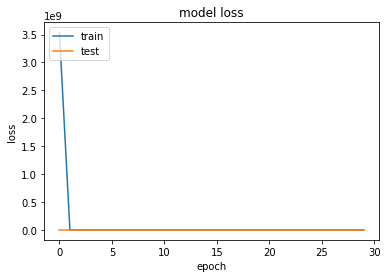

In [17]:
plt.plot(history1.history["loss"])
plt.plot(history1.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


In [18]:
# Computando as métricas para o teste
score = model1.evaluate(X_test, y_test, verbose=0)

In [19]:
print("Falsos negativos: ", score[1])
print("Falsos positivos: ", score[2])
print("Verdadeiros negativos: ", score[3])
print("Verdadeiros positivos: ", score[4])
print("Precisao: ", score[5])
print("Revocacao: ", score[6])

Falsos negativos:  81.0
Falsos positivos:  0.0
Verdadeiros negativos:  1033.0
Verdadeiros positivos:  0.0
Precisao:  0.0
Revocacao:  0.0


In [20]:
model1.reset_states() 

## 3) Melhorando o classificador

1. Ponderar as classes pois estão muito desbalanceadas
2. Normalizar os atributos

In [21]:
# normalizacao z-score
# calculamos média e desvio no treinamento e aplicamos em treinamento e teste
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train -= mean
X_test -= mean

X_train /= std
X_test /= std

In [22]:
# vamos ponderar o total de cada classe e formar pesos
peso_0 = 1.0 - (counts_train[0]/len(X_train))*0.5
peso_1 = 1.0 - (counts_train[1]/len(X_train))*1.5
print(peso_0, peso_1)

# ponderacao das classes
class_weight = {0: peso_0, 1: peso_1}

0.5394204851752021 0.8817385444743935


In [23]:
model2 = keras.Sequential(
    [
        keras.layers.Dense(
            16, activation="relu", input_shape=(X_train.shape[-1],)
        ),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model2.summary()

# compilamos o modelo utilizando:
#- um otimizador SGD
#- a função de perda entropia cruzada
#- as métricas acima
model2.compile(
    optimizer=keras.optimizers.SGD(1e-1), loss="binary_crossentropy", metrics=metrics
)

history2 = model2.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    class_weight=class_weight,
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
90/90 [==============================] - 5s 24ms/step - loss: 0.2760 - fn: 430.0000 - fp: 53.0000 - tn: 5081.0000 - tp: 2.0000 - precision: 0.0364 - recall: 0.0046 - val_loss: 0.2918 - val_fn: 81.0000 - val_fp: 1.0000 - val_tn: 1032.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
90/90 [==============================] - 0s 3ms/step - loss: 0.2016 - fn: 346.0000 - fp: 5.0000 - tn: 4096.0000 - tp: 5.0000 - precision: 0.5000 - recall: 0.0142 - val_loss: 0.2626 - val

90/90 [==============================] - 0s 2ms/step - loss: 0.1719 - fn: 299.0000 - fp: 6.0000 - tn: 4095.0000 - tp: 52.0000 - precision: 0.8966 - recall: 0.1481 - val_loss: 0.2277 - val_fn: 70.0000 - val_fp: 1.0000 - val_tn: 1032.0000 - val_tp: 11.0000 - val_precision: 0.9167 - val_recall: 0.1358
Epoch 26/30
90/90 [==============================] - 0s 3ms/step - loss: 0.1706 - fn: 298.0000 - fp: 6.0000 - tn: 4095.0000 - tp: 53.0000 - precision: 0.8983 - recall: 0.1510 - val_loss: 0.2471 - val_fn: 70.0000 - val_fp: 5.0000 - val_tn: 1028.0000 - val_tp: 11.0000 - val_precision: 0.6875 - val_recall: 0.1358
Epoch 27/30
90/90 [==============================] - 0s 3ms/step - loss: 0.1706 - fn: 292.0000 - fp: 7.0000 - tn: 4094.0000 - tp: 59.0000 - precision: 0.8939 - recall: 0.1681 - val_loss: 0.2404 - val_fn: 71.0000 - val_fp: 1.0000 - val_tn: 1032.0000 - val_tp: 10.0000 - val_precision: 0.9091 - val_recall: 0.1235
Epoch 28/30
90/90 [==============================] - 0s 3ms/step - loss: 0.1

In [24]:
# Computando as métricas para o teste
score2 = model2.evaluate(X_test, y_test, verbose=0)
print("Falsos negativos: ", score2[1])
print("Falsos positivos: ", score2[2])
print("Verdadeiros negativos: ", score2[3])
print("Verdadeiros positivos: ", score2[4])
print("Precisao: ", score2[5])
print("Revocacao: ", score2[6])

Falsos negativos:  70.0
Falsos positivos:  1.0
Verdadeiros negativos:  1032.0
Verdadeiros positivos:  11.0
Precisao:  0.9166666865348816
Revocacao:  0.1358024626970291


In [25]:
model2.reset_states() 

## 4) É possível melhorar ainda mais?

Vamos montar uma rede profunda!

In [26]:
model3 = keras.Sequential(
    [
        keras.layers.Dense(
            8, activation="relu", input_shape=(X_train.shape[-1],)
        ),
        keras.layers.Dense(8, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model3.summary()

# compilamos o modelo utilizando:
#- um otimizador SGD
#- a função de perda entropia cruzada
#- as métricas acima
model3.compile(
    optimizer=keras.optimizers.SGD(1e-1), loss="binary_crossentropy", metrics=metrics
)

history3 = model3.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    class_weight=class_weight,
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8)                 32        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
90/90 [==============================] - 5s 22ms/step - loss: 0.2696 - fn: 372.0000 - fp: 322.0000 - tn: 4812.0000 - tp: 60.0000 - precision: 0.1571 - recall: 0.1389 - val_loss: 0.2965 - val_fn: 80.0000 - val_fp: 0.0000e+00 - val_tn: 1033.0000 - val_tp: 1.0000 - val_precision: 1.0000 - val_recall: 0.0123
Epoch 2/30
90/90 [==============================] - 0s 3ms/step - los

Epoch 25/30
90/90 [==============================] - 0s 3ms/step - loss: 0.1359 - fn: 252.0000 - fp: 7.0000 - tn: 4094.0000 - tp: 99.0000 - precision: 0.9340 - recall: 0.2821 - val_loss: 0.9949 - val_fn: 15.0000 - val_fp: 447.0000 - val_tn: 586.0000 - val_tp: 66.0000 - val_precision: 0.1287 - val_recall: 0.8148
Epoch 26/30
90/90 [==============================] - 0s 3ms/step - loss: 0.1403 - fn: 249.0000 - fp: 40.0000 - tn: 4061.0000 - tp: 102.0000 - precision: 0.7183 - recall: 0.2906 - val_loss: 0.1696 - val_fn: 59.0000 - val_fp: 0.0000e+00 - val_tn: 1033.0000 - val_tp: 22.0000 - val_precision: 1.0000 - val_recall: 0.2716
Epoch 27/30
90/90 [==============================] - 0s 3ms/step - loss: 0.1303 - fn: 243.0000 - fp: 7.0000 - tn: 4094.0000 - tp: 108.0000 - precision: 0.9391 - recall: 0.3077 - val_loss: 0.1646 - val_fn: 59.0000 - val_fp: 0.0000e+00 - val_tn: 1033.0000 - val_tp: 22.0000 - val_precision: 1.0000 - val_recall: 0.2716
Epoch 28/30
90/90 [==============================] -

In [27]:
# Computando as métricas para o teste
score3 = model3.evaluate(X_test, y_test, verbose=0)

print("Rede rasa")
print("--------")
print("Falsos negativos: ", score2[1])
print("Falsos positivos: ", score2[2])
print("Verdadeiros negativos: ", score2[3])
print("Verdadeiros positivos: ", score2[4])
print("Precisao: %.3f" % score2[5])
print("Revocacao: %.3f\n" % score2[6])

print("Rede profunda")
print("--------")
print("Falsos negativos: ", score3[1])
print("Falsos positivos: ", score3[2])
print("Verdadeiros negativos: ", score3[3])
print("Verdadeiros positivos: ", score3[4])
print("Precisao: %.3f" % score3[5])
print("Revocacao: %.3f" % score3[6])

Rede rasa
--------
Falsos negativos:  70.0
Falsos positivos:  1.0
Verdadeiros negativos:  1032.0
Verdadeiros positivos:  11.0
Precisao: 0.917
Revocacao: 0.136

Rede profunda
--------
Falsos negativos:  59.0
Falsos positivos:  0.0
Verdadeiros negativos:  1033.0
Verdadeiros positivos:  22.0
Precisao: 1.000
Revocacao: 0.272


In [28]:
model3.reset_states() 